# __FINAL PROJECT PHASE II__

# __RESEARCH QUESTION:__

What set of criteria is most important to obtain the most viewership on Netflix from 2023 to 2025? Are we able to accurately predict viewership according to IMDb ratings and global availability? In the past two years, have films needed to be globally available in order to reach high popularity in terms of views of the movie?

To elaborate on the set of criterias at hand, viewership is the number of hours that a user watched a movie for divided by the runtime in hours acccumulated in the provided and observed period in our Netflix engagment reports.  These reports are collected semi-annually.  IMDb ratings are out of 10 in ascending order where 1 is lowest and 10 is highest and collected by IMDb. Global availability is whether or not a movie is able to be watched in all countries with Netflix.

### Data Overview & Sources:

In total, we collect seven data tables (linked below). The first five are taken from Netflix regarding semi-annual engagement reports starting from the first half of 2023 to the first half of 2025. Each report includes 2 tabs, (Shows and Films) or (Shows and Movies), and their respective data (i.e. runtime, viewership, global availability). The first half of 2023 report is an excpetion with only 1 tab of both shows and movies combined, but this gets handled in our data cleaning.

Meanwhile, the following two IMDb data tables are combined to give us an extensive IMDb table to cross reference with the Netflix engagement reports. The IMDb ratings data table contains all the movies and shows, each identified by a unique ID that is not the movie/show title. The IMDb titles data table provides these IDs and the actual title, allowing us to link each movie/show's ratings with their title. 

Finally, we used some outside sources to help us with code, and these sources are cited within their code cell.

Source for Netflix Engagement Report First Half 2023: https://about.netflix.com/en/news/what-we-watched-a-netflix-engagement-report

Source for Netflix Engagement Report Second Half 2023: https://about.netflix.com/en/news/what-we-watched-the-second-half-of-2023

Source for Netflix Engagement Report First Half 2024: https://about.netflix.com/en/news/what-we-watched-the-first-half-of-2024

Source for Netflix Engagement Report Second Half 2024: https://about.netflix.com/en/news/what-we-watched-the-second-half-of-2024

Source for Netflix Engagement Report First Half 2025: https://about.netflix.com/en/news/what-we-watched-the-first-half-of-2025

Source of IMDb Ratings for Movies/Shows: https://datasets.imdbws.com/title.ratings.tsv.gz

Source of IMDb Movie/Show Titles: https://datasets.imdbws.com/title.basics.tsv.gz

### Importing:

In [2]:
#imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import duckdb
from datetime import time
from sklearn.linear_model import LinearRegression, LogisticRegression
import re

In [3]:
pip install pandas openpyxl

Note: you may need to restart the kernel to use updated packages.


# __Data Collection & Cleaning:__

In [4]:
#import the dataset with all ratings from IMBb. 
#note that each rating has a unique ID, not the show/movie title
ratings_df= pd.read_table("title.ratings.tsv")

#import the dataset with movie title given the ID
titles_df= pd.read_table("title.basics.tsv")

In [5]:
#perform an SQL join to obtain a dataframe with the rating, number of votes for that rating, and title
merged_ratings_df= duckdb.sql("""SELECT r.tconst, r.averageRating, r.numVotes,
t.originalTitle AS Title
FROM ratings_df r, titles_df t
WHERE r.tconst=t.tconst""").df()

#drop the duplicate titles to prevent duplicate rows when merging with Netflix dataframe
merged_ratings_df = merged_ratings_df.drop_duplicates(subset=['Title'])

#look at the merged_ratings_df
#merged_ratings_df.to_csv("merged_ratings_df.csv", index=False)

We observe that in merged_ratings_df, the movie titles are truly titles, which is what we expected. However, many rows do not have show titles, only episode numbers. For example, the observation with the ID of tt0740721 has the corresponding Title, Episode #1.1.  
We attempted to fix this problem with show titles by looking for IMDb dataset(s) that would let us link the ID and episode number with a show title. We found another IMDb source, title.akas.tsv, that was stated to have the ID and title of the show, but after reading it in, we realized it did not provide the true titles. We then found another IMDb source, title.episode.tsv, that provided the ID, the show's season and episode number, and another parent ID. However, we could not locate the data source allowing us to reference the parent ID with the title. At this point, we made the decision to proceed with films only. 

In [6]:
#import the netflix engagement reports
#import 1st half of 2023 netflix data
all_jan_jun_2023= pd.read_excel("What_We_Watched_A_Netflix_Engagement_Report_2023Jan-Jun.xlsx",
                                  sheet_name="Engagement",
                                  skiprows=5)

#import 2nd half of 2023 netflix data
movies_jul_dec_2023= pd.read_excel("What_We_Watched_A_Netflix_Engagement_Report_2023Jul-Dec.xlsx",
                                  sheet_name="Film",
                                  skiprows=5)

#import the 1st half of 2024 netflix data
movies_jan_jun_2024= pd.read_excel("What_We_Watched_A_Netflix_Engagement_Report_2024Jan-Jun.xlsx",
                                   sheet_name= "Film",
                                   skiprows=5)

#import the 2nd half of 2024 netflix data
movies_jul_dec_2024= pd.read_excel("What_We_Watched_A_Netflix_Engagement_Report_2024Jul-Dec.xlsx",
                                   sheet_name= "Film",
                                   skiprows=5)
movies_jul_dec_2024['Time_Period']= "2024 H2"
#import the 1st half of 2025 netflix data
movies_jan_jun_2025= pd.read_excel("What_We_Watched_A_Netflix_Engagement_Report_2025Jan-Jun.xlsx",
                                   sheet_name= "Movies",
                                   skiprows=5)

#source used to figure out how to skip rows when importing Excel sheet:
#https://www.statology.org/pandas-read-excel-skip-rows/

In [7]:
#add the time periods of the observations
all_jan_jun_2023['Time_Period']= "2023 H1"
movies_jul_dec_2023['Time_Period']= "2023 H2"
movies_jan_jun_2024['Time_Period']= "2024 H1"
movies_jan_jun_2025['Time_Period']= "2025 H1"

In [8]:
#combine all these dataframes into 1 Netflix dataframe, named netflix_df
#note that the Release Date has several missing values and thus omit it
netflix2023= duckdb.sql("""SELECT 
                    Title, 
                    "Available Globally?" AS Global, 
                    "Hours Viewed" AS Hours_Viewed, 
                    Runtime, Views, Time_Period
                FROM movies_jul_dec_2023 
                UNION 
                SELECT
                    Title, 
                    "Available Globally?" AS Global, 
                    "Hours Viewed" AS Hours_Viewed, 
                    NULL AS Runtime, 
                    NULL AS Views, Time_Period
                FROM all_jan_jun_2023""").df()

print(netflix2023.shape)

jan_jun_2024= duckdb.sql("""SELECT
                                Title, 
                                "Available Globally?" AS Global, 
                                "Hours Viewed" AS Hours_Viewed, 
                                Runtime, Views, Time_Period
                            FROM movies_jan_jun_2024""").df()

jul_dec_2024= duckdb.sql("""SELECT
                                Title, 
                                "Available Globally?" AS Global, 
                                "Hours Viewed" AS Hours_Viewed, 
                                Runtime, Views, Time_Period
                            FROM movies_jul_dec_2024""").df()

netflix2024= duckdb.sql("""SELECT * FROM jan_jun_2024 UNION ALL SELECT * FROM jul_dec_2024""").df()
#print(len(movies_jan_jun_2024) + len(movies_jul_dec_2024))
print(netflix2024.shape)

netflix2025= duckdb.sql("""SELECT
                                Title, 
                                "Available Globally?" AS Global, 
                                "Hours Viewed" AS Hours_Viewed, 
                                Runtime, Views, Time_Period
                            FROM movies_jan_jun_2025""").df()


print(netflix2025.shape)

netflix_df= duckdb.sql("""SELECT * FROM netflix2023 UNION SELECT * FROM netflix2024 UNION SELECT * 
FROM netflix2025""").df()

print(netflix_df.shape)

#UNION operator source: https://www.w3schools.com/sql/sql_union.asp

(27609, 6)
(18040, 6)
(8674, 6)
(54323, 6)


At this point, we have created a dataframe, netflix_df, that includes every film's viewership from the start of 2023 until the first half of 2025. We also printed the shapes of every dataframe to confirm that the netflix_df equals the sum of each year's number of observations.  
Next, we want to match each film with its IMDb rating, if a rating exists. Unfortunately, the Netflix and IMDb sources do not have a standardized convention for their film titles. In the following several code cells, we make an effort to clean the titles as much as possible, to improve the number of matches when we merge the Netflix and ratings dataframes.

In [9]:
#Netflix films with foreign language titles have both english translation then the foreign title
#cut the title of netflix shows with foreign language titles, keeping the english title only
mod_title= netflix_df['Title']
mod_title= mod_title.str.replace(r" \/\/.*", "", regex=True)

netflix_df['Title']= mod_title

#check that the foreign language component is gone
#netflix_df.head()

#One of us previously did similar work with meta characters and string detect/string replace in R,
#but used help with the string replace:
#https://stackoverflow.com/questions/5658369/how-to-input-a-regex-in-string-replace

In [10]:
#look at netflix titles
netflix_df.to_csv("netflix_titles.csv", index=False)
merged_ratings_df.to_csv("imdb_titles.csv", index=False)

In [36]:
#some Netflix titles end with the year in parenthesis, which is not seen in ratings titles

year_tester= netflix_df["Title"].str.endswith(")")

#removing the last 6 characters cuts the (Year) component if it is at the end of the title
netflix_df.loc[year_tester, "Title"]= netflix_df.loc[year_tester, "Title"].str[:-6]

#check that the (Year) component is gone
#year_tester_2= netflix_df["Title"].str.endswith(")")
#netflix_df[year_tester_2].head()

#source used for the str.endswith:
#https://www.w3schools.com/python/ref_string_endswith.asp

The netflix_df will now have more matches with the merged_ratings_df. We will now merge the two datasets with an INNER JOIN so that only the netflix films with ratings in IMDb are kept.

In [48]:
#Inner join Netflix and ratings datasets
netflix_ratings_df= duckdb.sql("""SELECT netflix_df.Title, netflix_df.Global, 
netflix_df.Hours_Viewed, netflix_df.Runtime, netflix_df.Views, netflix_df.Time_Period, 
merged_ratings_df.averageRating, merged_ratings_df.numVotes
FROM netflix_df
INNER JOIN merged_ratings_df
ON netflix_df.Title= merged_ratings_df.Title
""").df()
print(netflix_ratings_df.shape)

(26413, 8)


Next, we will clean the netflix_ratings_df to make it ready for analysis. Please see below.

In [49]:
#Grouping by titles to drop the duplicates.
#Taking the row with the maximum views because this is the row with peak popularity 
netflix_ratings_df = netflix_ratings_df.sort_values(by=["Views"], ascending=False)
netflix_ratings_df = netflix_ratings_df.drop_duplicates(["Title"], keep="first")
print(f"Our dataset has {netflix_ratings_df.shape[0]} number of films")

Our dataset has 8772 number of films


The 2023 data only has hours viewed, not viewership. We will fill the missing values with the hours viewed divided by the average runtime. We are choosing to do this so that we do not have to drop the 2023 data nor have empty data values.  
The Hours Viewed has the accurate data, and dividing it by the average runtime which is a constant means the transformation is not skewed. The average runtime is the best choice to transform the hours viewed because the runtime of a movie is unlikely to be extremely different in 2023-2025 compared to just 2023. 

In [50]:
#making time column to have type time, then adjusting runtime to be in minutes
netflix_ratings_df["Runtime"] = pd.to_datetime(netflix_ratings_df['Runtime'], format='%H:%M')
netflix_ratings_df["Runtime"] = netflix_ratings_df[
    "Runtime"].dt.hour*60 + netflix_ratings_df["Runtime"].dt.minute

#Finding average runtime and plugging it in to the missing values of runtime without skewing the data 
#to complete the dataframe enabling us to make future analysis
avgRuntime = np.round(np.mean(netflix_ratings_df["Runtime"]))
isEmptyRuntime = netflix_ratings_df["Runtime"].isna()
netflix_ratings_df.loc[isEmptyRuntime, "Runtime"] = avgRuntime

#Calculating views for empty values for Views column using runtime and hours viewed
isEmptyViews = netflix_ratings_df["Views"].isna()
netflix_ratings_df.loc[isEmptyViews, "Views"] = netflix_ratings_df["Hours_Viewed"]/np.round(
    avgRuntime/60)

To finish the dataset preparation, we will create a couple more columns to be used in future analysis.

In [51]:
#create new columns to use in future binary analysis on global avaiability 
netflix_ratings_df["Is_Global"] = netflix_ratings_df["Global"].map({'Yes': 1, 'No': 0})

#create new column that determines popularity based on being above and below average views
netflix_ratings_df["Popularity"] = netflix_ratings_df["Views"] > np.mean(netflix_ratings_df["Views"])
netflix_ratings_df["Popularity"] = netflix_ratings_df["Popularity"].map({True: int(1), False: int(0)})

#create new column that determines the number of reviews (numVotes) to be greater than 
#or less than the median
netflix_ratings_df["Sufficient Votes"] = netflix_ratings_df["numVotes"] > np.median(
    netflix_ratings_df["numVotes"])
netflix_ratings_df["Sufficient Votes"] = netflix_ratings_df["Sufficient Votes"].map(
    {True: int(1), False: int(0)})

In [52]:
#let's look at our cleaned dataset
print(netflix_ratings_df.head())

                Title Global  Hours_Viewed  Runtime      Views Time_Period  \
2978   Back in Action    Yes     313000000    114.0  164700000     2025 H1   
24825          Damsel    Yes     263700000    110.0  143800000     2024 H1   
14003        Carry-On    Yes     274500000    120.0  137300000     2024 H2   
4563        The Union    Yes     238200000    109.0  131100000     2024 H2   
4936             Lift    Yes     230800000    107.0  129400000     2024 H1   

       averageRating  numVotes  Is_Global  Popularity  Sufficient Votes  
2978             5.9     62144          1           1                 1  
24825            8.6         7          1           1                 0  
14003            6.5    181168          1           1                 1  
4563             7.2        18          1           1                 0  
4936             7.8        37          1           1                 0  


# __Data Description:__


Our dataframe was created by joining multiple Netflix engagement reports from different periods and merged with the IMDb ratings dataset to observe if any factors had the most influence on viewership for Netflix films and predict viewership for films outside of the dataset according to observed criteria. The cleaned dataset for analysis consists of 8772 Netflix films watched from January 2023 to June 2025, along with their respective attributes in terms of global availability, hours viewed, runtime, views, average IMDb rating, number of votes (defined in the next cell).

All source datasets used during this phase and their creation were funded by either Netflix or IMDb. In the earliest engagement report, Netflix states that the dataset representing 99% of all viewing on Netflix, so there is low concern that data is not recorded. Because IMDb ratings are made by users, it is possible that the most recent movies or those with low audience engagement are not observed in the IMDb source dataset. However, these concerns have little impact on our cleaned dataset, which spans until June of 2025 which is 4 months ago and only has movies with over 100,000 Netflix views (thus likely getting some ratings). Both Netflix viewers and IMDb reviewers should reasonably know that their behavior is tracked, although they may not know their data would be used to make these public datasets. Fot Netflix viewers, Netflix recommends shows based off of previous titles watched, so users know their watching is monitored. For IMDb reviewers, everyone's ratings are public on the site, so they know their ratings are not private. We do not forsee a notable change in viewing or rating behavior due to the fact that people consider that their data gets collected for a dataset. 

As a whole, both the Netflix and IMDb original data sources were preprocssed into (mostly) consistent datasets, but the column names were not consistent with each other. Our original plan was to create a dataset containing both Netflix films and shows, but upon merging with the IMDb dataset, we discovered that many shows were missing rating information and so we decided to focus solely on films. This meant reducing our dataset, but given that we are still able to work with around 8,772 instances of films, we should have sufficient data for performing exploratory analysis. We decided to retain the majority of the attributes found in both the Netflix and IMDb datasets since our research aims to identify which factors most strongly influence viewership. Removing such attributes could limit the scope of our findings later on.

Much of the data cleaning that was performed using SQL. Our first task involved merging the IMDb datasets together, as title.ratings.tsv only contains ratings corresponding to an ID and not a film title while title.basics.tsv includes the corresponding film title along with their respective IDs. By performing a SQL join on these two datasets, we obtained a single dataframe containing both film titles and their ratings. 

The second task was to combine all of Netflix’s semi-annual engagement datasets into a master dataset. Using the UNION ALL operator in SQL, we were able to successfully retain all instances from all four datasets. During this process, we also noticed that some Netflix films contained titles in their original languages which would be a problem when merging with the IMDb dataset that only has titles in English. To ensure consistent title matching, we cleaned up the film titles by removing the extra info that followed // by simply replacing a part of the title string with an empty string. Additionally, for titles that had it, we cleaned the film titles by removing the year in parenthesis.

Once that was done, we performed an inner join between our Netflix and IMDb datasets using the shared column Title. This join type allowed us to keep only instances of the Netflix dataset with corresponding IMDb data, so our dataset would not have missing rating values. 

Additionally, we created dummy variables like Is_Global and Popularity, to support our exploratory analysis. The Is_Global variable was encoded as 1 for films globally available and 0 for unavailable. The column, Popularity, that marked whether a film had more than the median views was created and then converted into a binary variable with 1 being popular and 0 for not popular.

All raw source data can be found on the Github folder which can also be accessed here. 
https://github.com/xuanlianliu/Data_Science_Project

Further definitions of our columns:  
Title: the title of the film (must match in both Netflix and IMDb)  
Global: either "Yes" or "No" to the film's ability to be watched in all countries with Netflix  
Hours_Viewed: the number of hours the film was watched, accumulated in the time period  
Runtime: the length of the film  
Views: the Hours_Viewed multiplied by the Runtime  
Time_Period: the time interval in which the viewership data was collected. Is measured semi-annually, either Jan-Jun or Jul-Dec  
average_Rating: the rating given by IMDb users, out of 10 in ascending order where 1 is lowest and 10 is the highest  
numVotes: the number of votes cast for the film  
Is_Global: measures global availibility, encoded as 1 for films globally available and 0 for unavailable  
Popularity: measures whether a film had more than the median views was created, encoded as 1 being popular and 0 for not popular  
Sufficient Votes: measures whether a film recieved sufficient votes, defined as more than the median number of votes, encoded as 1 being sufficient votes and 0 for not sufficient

# __Data Limitations:__


There were several limitations we discovered in our dataset. 
- The Netflix source began with a release date column, which were missing many values, so we ultimately chose not to include this variable in our dataset. However, this exacerbates our time interval limitation: our dataset only covers a 2.5-year period worth of Netflix data spanning from January 2023 to June 2025. This short timeframe might make it hard for us to generalize our findings to other years and their films and may affect the accuracy of our predictive models. Additionally, the first half of 2023 dataset was missing 2 important variables: runtime and number of views. We filled these missing columns with their respective averages but this approach risks suggesting a consistent pattern across all the first half of 2023 films. While the missing values have been addressed, these are not exactly the true runtime and view values which could cause some discrepancies in our data analysis. In the graph of views over time, the aggregate views in 2023 is significantly lower than in each later period. We believe the reason for this unusual result is the lack of full data in the source for the first half of 2023.
- Our Netflix dataset contains duplicates of certain films as they appeared in multiple engagement reports during collection. To address this, we removed the duplicates and kept only the instance with its max views. Such removal might reduced the total number of views for certain Netflix time periods and alter our observations of viewership over time.
- We also experienced limitations from the ratings dataset. Not every Netflix title matches with an IMDb rating, so there are many missing ratings. This harms our predictions of viewership based on ratings because many films are missing from the analysis. Specifically when considering naming across Netflix and IMDb, we think the titles with complex titles and those with alternate release names in different regions are most likely to not have exact matches between Netflix and IMDb, due to formatting inconsistencies. This could affect the analysis by disproportionately reducing the number of regional films compared to international, widespread films, making it appear that regional films are less watched than in reality.
- Other limitations arise from the fact that anyone on IMDb can rate a film. Not all reviews are the same quality because there is no verification of whether or not they truly watched the film or have external motives (e.g., review bombing for personal enjoyment or rating highly just because their favorite actor is in it). This could impact our analysis by creating trends that do not exist from those who did not watch the movie as a genuine viewer. In addition, people who rated films on IMDb may have watched them in ways other than Netflix. In other words, the ratings bring in people who are not related with Netflix into our cleaned dataset, so our analysis could be inaccurate if the Netflix reviewers think differently compared to non-Netflix reviewrs.
- We observe variation in the number of votes that determined each film’s IMDb rating. Films with a smaller number of votes could skew the rating, which could ultimately affect our analysis of how ratings correlate with viewership.
- Mainstream movies are likely to garner more viewership than indie movies overall. Since we took the average of views to determine the baseline for what makes a movie popular, it means that many mainstream movies will automatically be considered popular because of their high view count.

# __Exploratory Data Analysis:__


### Movie Viewership based on Ratings and Global Availability:

Linear Regression (x - ratings, y - viewership), Avg Views on each rating as bar graph

To help gauge whether or not there is a relationship between Views and Ratings and the relationship between Views and Global Availability, we need a series of graphs.

Conduct a scatterplot analysis on the number of views for a movie based on the ratings and global availability.

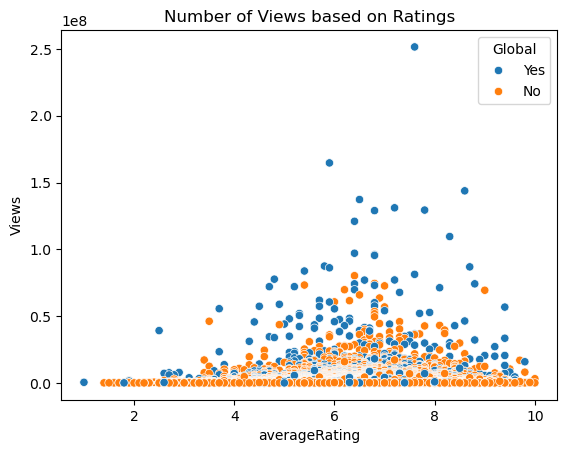

In [17]:
plot = sns.scatterplot(netflix_ratings_df, 
             x='averageRating', y='Views', marker='o', hue="Global")
plt.title("Number of Views based on Ratings");

Conduct a scatterplot analysis on the hours viewed for a movie based on the ratings and global availability.

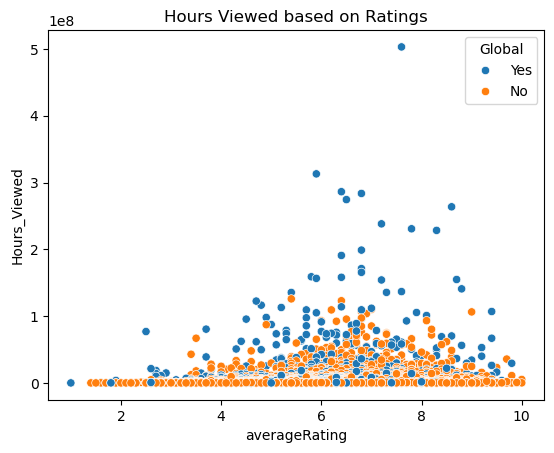

In [18]:
plot = sns.scatterplot(netflix_ratings_df, 
             x='averageRating', y='Hours_Viewed', marker='o', hue="Global")
plt.title("Hours Viewed based on Ratings");

### Movie Viewership over Time:

The below graph is to build an understanding of how much time (in hours) is spent watching films in each time period.

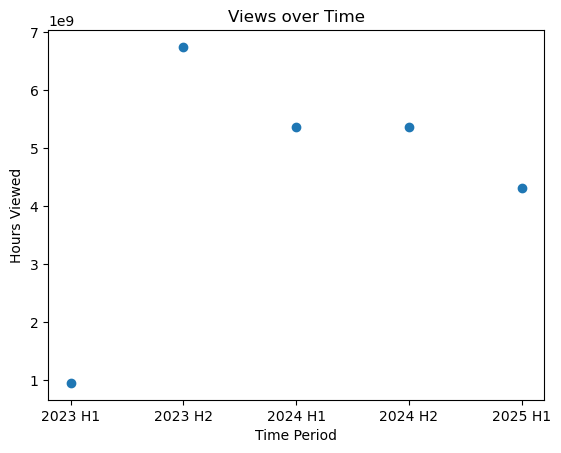

In [19]:
#find the total views per each time period
netflix_summarized= duckdb.sql("""SELECT Time_Period,
SUM(Views) as Total_Views,
FROM netflix_ratings_df
WHERE Views IS NOT NULL
GROUP BY Time_Period
ORDER BY Time_Period ASC""").df()

#graph the views over time with a scatterplot
viewership_plot= plt.plot(netflix_summarized['Time_Period'], netflix_summarized['Total_Views'], 'o')
plt.title("Views over Time")
plt.xlabel('Time Period')
plt.ylabel('Hours Viewed')
plt.show()

The above graph shows that Netflix subscribers greatly increased their viewership from first half of 2023 to the second half of 2024, watching 6 times as many hours. Logically, this result is not realistic, and we will discuss possible reasons why in the limitations section. 
The below graph shows the top films and their views by the time period.

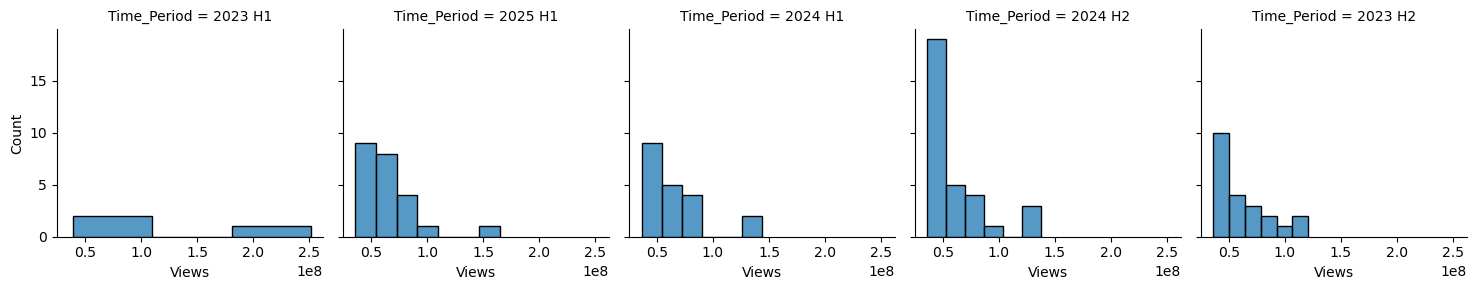

In [20]:
#Top 100 films

netflix_top_100= duckdb.sql("""SELECT *
FROM netflix_ratings_df
WHERE Views IS NOT NULL
ORDER BY Views DESC
LIMIT 100""").df()

g=sns.FacetGrid(netflix_top_100, col="Time_Period")
g.map_dataframe(sns.histplot, x="Views")
plt.show()

### Correlation and Regression

Now, we will create a multi-variable correlation matrix to examine the strength and directions of relationships with the following variables: Views, Hours Viewed, Runtime, Global Availability, Average Rating, Number of Votes, and Popularity.

In [21]:
corr_df = netflix_ratings_df[['Views', 'Hours_Viewed', 'Runtime', 'Is_Global', 
                              'averageRating', 'numVotes', 'Popularity']].corr()
corr_df

,Views,Hours_Viewed,Runtime,Is_Global,averageRating,numVotes,Popularity
Views,1.000000,0.984744,0.032094,0.205155,0.029954,0.083142,0.506780
Hours_Viewed,0.984744,1.000000,0.092813,0.193198,0.039240,0.095755,0.493987
Runtime,0.032094,0.092813,1.000000,-0.103808,0.144562,0.171030,0.068014
Is_Global,0.205155,0.193198,-0.103808,1.000000,-0.000392,-0.081548,0.188837
averageRating,0.029954,0.039240,0.144562,-0.000392,1.000000,0.114741,0.023790
numVotes,0.083142,0.095755,0.171030,-0.081548,0.114741,1.000000,0.186709
Popularity,0.506780,0.493987,0.068014,0.188837,0.023790,0.186709,1.000000


The correlation matrix displays a very high correlation, 0.98, between Views and Hours Viewed, and this clearly makes sense because being viewed (the number of views) is linked with being viewed (in hours). We also observe a positive correlation of 0.20 between Views and being globally available, a positive correlation of 0.02 between Views and Average Rating, a postive correlation of 0.07 between Views and Number of Votes, and 0.51 between Views and Popularity.

We will fit a linear regression model predict view counts given the ratings.

The model's slope is: 203983.77
The model's intercept is: 1273758.73


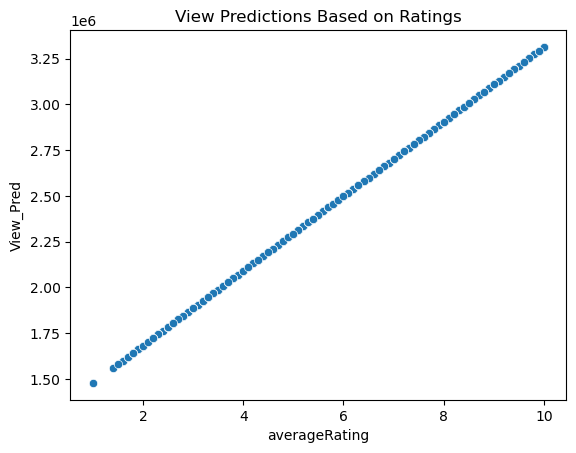

In [22]:
no_nan_df = netflix_ratings_df.copy().dropna()
x = no_nan_df[['averageRating']].values
y = no_nan_df[['Views']].values

ratings_model = LinearRegression().fit(x,y)
print("The model's slope is: " + str(round(float(ratings_model.coef_[0][0]),2)))
print("The model's intercept is: " + str(round(float(ratings_model.intercept_[0]),2)))

no_nan_df["View_Pred"] = ratings_model.predict(x)
plot2 = sns.scatterplot(no_nan_df, 
             x='averageRating', y='View_Pred')
plt.title("View Predictions Based on Ratings");


We will fit a logistic regression model to determine the coefficient and intercept to see how the odds of the popularity change for each unit of increase in ratings.

In [23]:
x = netflix_ratings_df['averageRating'].values.reshape(-1, 1)
y = netflix_ratings_df['Popularity']
model = LogisticRegression().fit(x,y)

print(model.coef_[0][0])
print(model.intercept_[0])

0.04864940946624864
-1.7204399866077065


Using the model's predict_proba, we can find the probability of a movie being successful based on the average rating.

<Axes: xlabel='averageRating', ylabel='popularity_pred'>

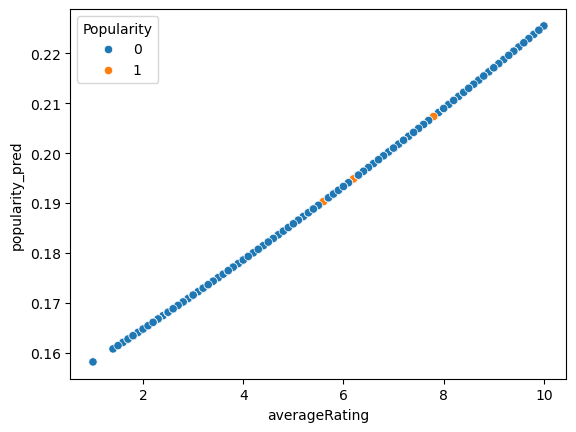

In [24]:
netflix_ratings_df['popularity_pred'] = model.predict_proba(netflix_ratings_df[
    ['averageRating']].values)[:, 1]
sns.scatterplot(x = netflix_ratings_df['averageRating'], 
                y = netflix_ratings_df['popularity_pred'], hue = netflix_ratings_df['Popularity'])                                                           

The graph below allows us to visualize how the number of votes changes in relation to the average rating.

<Axes: xlabel='averageRating', ylabel='numVotes'>

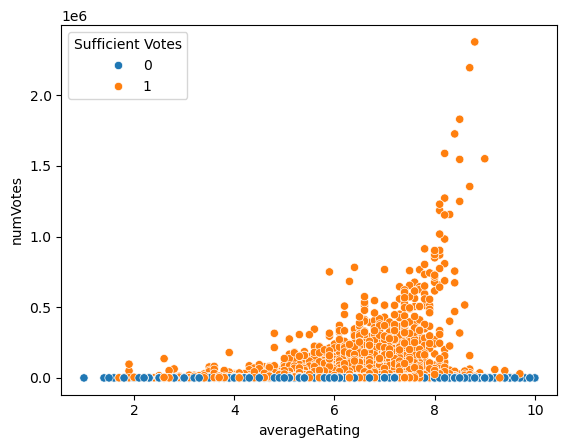

In [25]:
sns.scatterplot(netflix_ratings_df, x = 'averageRating', y= 'numVotes', hue='Sufficient Votes')

### Global Availability Pie Charts:

The following pie charts are meant to visualize the bearing that the trait of global analysis has on popularity. Findings are stated at the end of this section.

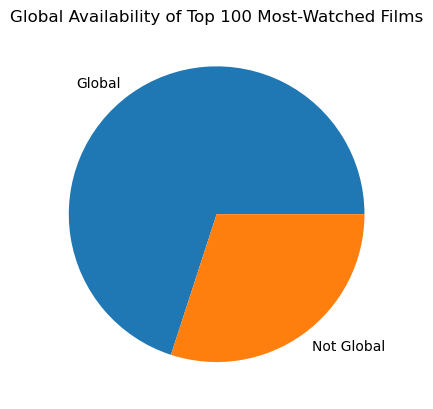

In [26]:
#Top 100 viewed films by global availability
yes_count = (netflix_top_100["Global"]=="Yes").sum()
no_count  = (netflix_top_100["Global"]=="No").sum()

y = np.array([yes_count, no_count])
mylabels = ["Global", "Not Global"]

plt.pie(y, labels = mylabels)
plt.title("Global Availability of Top 100 Most-Watched Films")
plt.show() 

#creating pie chart source:
#https://www.w3schools.com/python/matplotlib_pie_charts.asp

Text(0.5, 1.0, 'Popularity For Globally Available Films')

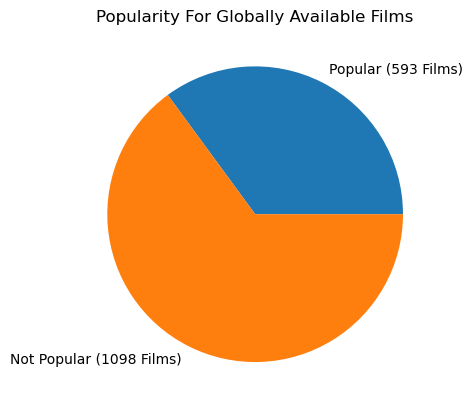

In [27]:
#Global availabilty to be popular
global_df= duckdb.sql("""SELECT *
FROM netflix_ratings_df
WHERE Global== 'Yes'""").df()
global_and_popular= (global_df["Popularity"]==1).sum()
global_and_not_popular= (global_df["Popularity"]==0).sum()

y = np.array([global_and_popular, global_and_not_popular])
mylabels = [f"Popular ({global_and_popular} Films)", 
            f"Not Popular ({global_and_not_popular} Films)"]

plt.pie(y, labels = mylabels)
plt.title("Popularity For Globally Available Films")

Text(0.5, 1.0, 'Popularity For Non-Globally Available Films')

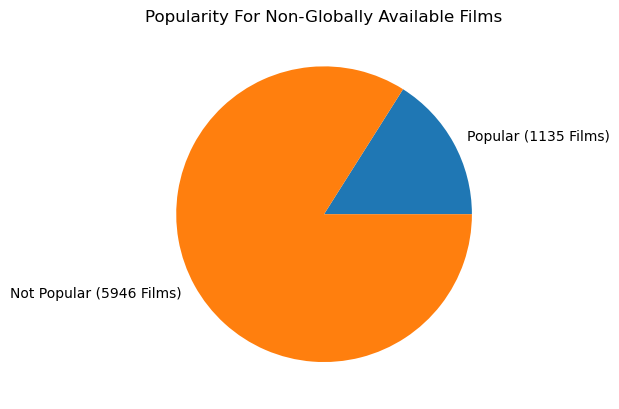

In [28]:
not_global_df= duckdb.sql("""SELECT *
FROM netflix_ratings_df
WHERE Global== 'No'""").df()
not_global_and_popular= (not_global_df["Popularity"]==1).sum()
not_global_and_not_popular= (not_global_df["Popularity"]==0).sum()

y = np.array([not_global_and_popular, not_global_and_not_popular])
mylabels = [f"Popular ({not_global_and_popular} Films)", 
            f"Not Popular ({not_global_and_not_popular} Films)"]

plt.pie(y, labels = mylabels)
plt.title("Popularity For Non-Globally Available Films")

First, out of the most 100 most viewed films in our dataset, approximately 2/3 of them are globally available and 1/3 are not globally available.
Second, when only considering the globally available films, around 1/3 are popular.
Third, when considering only the non-globally available films, around 0.16 are popular.

# __Questions for Reviewers:__


How can we improve the merge of the netflix films and the IMDb ratings? There is certainly variation in the way that films are listed across the two sources, which causes us to have more missing ratings than what exists. Currently, we are joining by title after removing the foreign language and (year) parts of the netflix titles, but are there other actions we can take?

Based on our current exploratory data analyses, do you think any analyses are especially suitable and recommended to move forwards with for phase 3? What additional work are we expected to do to bring our phase 2 exploratory analysis to the futher stages?

Are there other strong graphs we can make to explore our research question?

Do we sufficiently address the problems/limitations through our data cleaning, and if not, any suggestions for how we can we further treat our dataset to reduce the data limitations?